In [1]:
import os
import re
import pandas as pd
from pandasql import sqldf

pysqldf = lambda q: sqldf(q, globals())

invest_date_first = '2001-04-24'
invest_date_last = '2009-12-15'

In [2]:
ETF = 'QQQ'
ETF_3x = 'TQQQ'

In [3]:
qqq  = pd.read_csv(
    'history/{}.csv'.format(ETF),
    )

qqq['id'] = qqq.index

In [6]:
qqq = pysqldf(u"""
    select qqq.*, 
    pre_day.Date as pre_Date,
    pre_day.Close as pre_Close,
    (qqq.Close - pre_day.Close)/pre_day.Close AS Perent    
    from qqq 
    left join qqq as pre_day on pre_day.id+1 = qqq.id
    order by qqq.Date asc
    """)

qqq.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume,id,pre_Date,pre_Close,Perent,pre_Date,pre_Close,Perent
0,1999-03-10,51.1250,51.156250,50.28125,51.0625,44.175228,5232000,0,None,NaN,NaN,None,NaN,NaN
1,1999-03-11,51.4375,51.734375,50.31250,51.3125,44.391483,9688600,1,1999-03-10,51.0625,0.004896,1999-03-10,51.0625,0.004896
2,1999-03-12,51.1250,51.156250,49.65625,50.0625,43.310101,8743600,2,1999-03-11,51.3125,-0.024361,1999-03-11,51.3125,-0.024361


In [7]:
data_list = pysqldf(u"""
    select 
    Date,
    Perent as Perent, 
    3*Perent as `3x Percent`
    from qqq
    where Perent is not null
    """).to_dict('records')

In [13]:
start_price = qqq['Close'][0]

qqq_price = start_price
tqqq_price = start_price

for r in data_list:
    ###
    qqq_price = qqq_price*(1+r['Perent'])
    r['price'] = qqq_price
    ###
    tqqq_price = tqqq_price*(1+r['3x Percent'])    
    r['3x price'] = tqqq_price  

data1 = pd.DataFrame(data_list)

<AxesSubplot:xlabel='Date'>

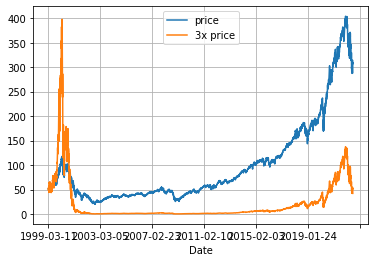

In [14]:
data1.plot(x ='Date', y=[
    'price', 
    '3x price',
    ], grid = True)

tqqq vs 3x qqq

In [15]:
data_3x  = pd.read_csv(
    'history/{}.csv'.format(ETF_3x),
    )

In [16]:
compare_3x = pysqldf(u"""
    select 
    data1.Date,
    data1.`3x price`,
    data_3x.Close
    from data_3x
    join data1 on data1.Date = data_3x.Date
    order by data1.Date asc
    """)

In [17]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [18]:
X = compare_3x['3x price'].to_numpy()
X = np.array([[i] for i in X])
y = compare_3x['Close'].to_numpy()

In [19]:
reg = LinearRegression().fit(X, y)

In [20]:
reg.score(X, y)

print(reg.coef_)

print(reg.intercept_)

[0.64351346]
0.3260791551305271


In [21]:
result = pysqldf(u"""
    select 
    Date,
    `3x price` * {} + {} AS simulated_Close,
    Close
    from compare_3x
    """.format(
    reg.coef_[0],
    reg.intercept_))

<AxesSubplot:xlabel='Date'>

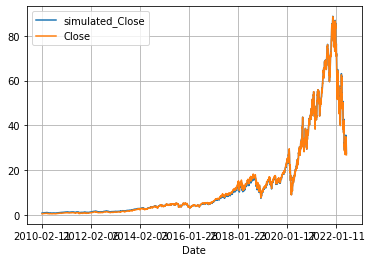

In [22]:
result.plot(x ='Date', y=[
    'simulated_Close', 
    'Close',
    ], grid = True)

all simulation results

In [23]:
final_result = pysqldf(u"""
    select 
    data1.Date,
    data1.price AS {},
    data1.`3x price` * {} + {} AS simulated_{},
    data_3x.Close as {}
    from data1
    left join data_3x on data_3x.Date = data1.Date
    """.format(
    ETF,
    reg.coef_[0],
    reg.intercept_,
    ETF_3x,
    ETF_3x
    ))

<AxesSubplot:xlabel='Date'>

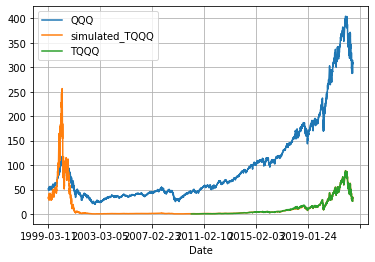

In [24]:
final_result.plot(x ='Date', y=[
    ETF, 
    'simulated_{}'.format(ETF_3x),
    ETF_3x,
    ], grid = True)

In [25]:
final_result.to_excel(
    '{}_leverage_simulation.xlsx'.format(ETF),
    index = False,
    )

END